In [1]:
from pathlib import Path
from typing import Iterable, Sequence
import re

import pandas as pd
import plotnine as gg
import janitor


In [2]:
_ = gg.theme_set(
    gg.theme_classic()
    + gg.theme(
        axis_ticks=gg.element_blank(), 
        strip_background=gg.element_blank(), 
        panel_grid_major_y=gg.element_line(),
    )
)
%matplotlib inline
%config InlineBackend.figure_format='retina'

library_pal = {"pymc3": "#12698A", "stan": "#B2001D"}

In [3]:
project_root_dir = Path("..")
benchmarks_dir = project_root_dir / "benchmarks"
n_benchmarks = len(list(benchmarks_dir.iterdir()))
print(f"number of benchmark files: {n_benchmarks}")

model_size_csv = project_root_dir / "model-result-file-sizes.csv"
assert model_size_csv.is_file() and model_size_csv.exists()


number of benchmark files: 640


| colname   |   type (unit)   | description                                                                                                                                                                         |
|-----------|:---------------:|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| s         | float (seconds) | Running time in seconds                                                                                                                                                             |
| h:m:s     |    string (-)   | Running time in hour, minutes, seconds format                                                                                                                                       |
| max_rss   |    float (MB)   | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used.                                                                                            |
| max_vms   |    float (MB)   | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process                                                                                       |
| max_uss   |    float (MB)   | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now.                                                |
| max_pss   |    float (MB)   | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only) |
| io_in     |    float (MB)   | the number of MB read (cumulative).                                                                                                                                                 |
| io_out    |    float (MB)   | the number of MB written (cumulative).                                                                                                                                              |
| mean_load |    float (-)    | CPU usage over time, divided by the total running time (first row)                                                                                                                  |
| cpu_time  |     float(-)    | CPU time summed for user and system                                                                                                                                                 |

In [4]:
def read_benchmark(file: Path) -> pd.DataFrame:
    return (
        pd.read_table(file, sep="\t")
        .assign(name=file.name.replace(file.suffix, ""))
        .reset_index(drop=False)
        .rename(columns={"index": "bench_rep"})
    )


def stan_or_pymc3(names: Iterable[str]) -> list[str]:
    return [re.findall("stan|pymc3", n)[0] for n in names]


def _fix_simple_model_names(names: Iterable[str]) -> list[str]:
    new_names: list[str] = []
    for name in names:
        new_names.append(
            name.replace("simple-pymc3-", "simple_pymc3_").replace(
                "simple-stan-", "simple_stan_"
            )
        )
    return new_names


def parse_model_names(df: pd.DataFrame, col: str = "name") -> pd.DataFrame:
    return df.assign(
        library=lambda d: stan_or_pymc3(d[col]),
        model=lambda d: [x.split("_")[0].strip() for x in d[col]],
        data_size=lambda d: [x.split("_")[2].strip() for x in d[col]],
        replicate=lambda d: [int(x.split("__")[1].strip()) for x in d[col]],
    )


benchmarks = (
    pd.concat(read_benchmark(f) for f in benchmarks_dir.iterdir() if f.suffix == ".tsv")
    .assign(name=lambda d: _fix_simple_model_names(d.name))
    .reset_index(drop=True)
    .pipe(parse_model_names)
    .assign(time_minutes=lambda d: d.s / 60.0)
    .sort_values(["model", "library", "data_size", "replicate", "bench_rep"])
)
benchmarks.head(10)


,bench_rep,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,name,library,model,data_size,replicate,time_minutes
1060,0,157.0689,0:02:37,888.70,3256.28,237.42,246.27,0.06,95.09,8.57,37.74,2tier-hier_pymc3_10-10-5-5__1,pymc3,2tier-hier,10-10-5-5,1,2.617815
1061,1,38.9792,0:00:38,249.58,976.44,244.29,244.42,0.02,7.11,21.23,8.90,2tier-hier_pymc3_10-10-5-5__1,pymc3,2tier-hier,10-10-5-5,1,0.649653
1062,2,34.6555,0:00:34,229.78,974.37,224.77,224.91,0.00,7.88,26.18,8.93,2tier-hier_pymc3_10-10-5-5__1,pymc3,2tier-hier,10-10-5-5,1,0.577592
1063,3,40.1311,0:00:40,232.88,974.37,227.70,227.84,0.00,7.86,22.45,8.08,2tier-hier_pymc3_10-10-5-5__1,pymc3,2tier-hier,10-10-5-5,1,0.668852
1064,4,38.9467,0:00:38,237.24,974.45,232.02,232.16,0.00,8.48,20.88,8.72,2tier-hier_pymc3_10-10-5-5__1,pymc3,2tier-hier,10-10-5-5,1,0.649112
1165,0,154.5477,0:02:34,833.35,3256.34,204.80,216.05,0.06,95.09,9.14,33.01,2tier-hier_pymc3_10-10-5-5__2,pymc3,2tier-hier,10-10-5-5,2,2.575795
1166,1,38.7148,0:00:38,248.48,976.81,204.54,215.84,0.00,8.45,21.01,8.54,2tier-hier_pymc3_10-10-5-5__2,pymc3,2tier-hier,10-10-5-5,2,0.645247
1167,2,40.7164,0:00:40,223.93,974.37,185.11,193.82,0.00,7.88,20.49,8.56,2tier-hier_pymc3_10-10-5-5__2,pymc3,2tier-hier,10-10-5-5,2,0.678607
1168,3,38.9092,0:00:38,226.15,956.39,183.85,194.33,0.00,8.43,21.22,8.43,2tier-hier_pymc3_10-10-5-5__2,pymc3,2tier-hier,10-10-5-5,2,0.648487
1169,4,36.1236,0:00:36,239.01,1000.94,196.68,207.18,0.00,7.89,23.33,8.65,2tier-hier_pymc3_10-10-5-5__2,pymc3,2tier-hier,10-10-5-5,2,0.602060


In [5]:
benchmark_metrics = [
    "time_minutes",
    "max_rss",
    "max_vms",
    "max_pss",
    "cpu_time",
    "mean_load",
]
benchmark_ids = ["name", "model", "library", "data_size", "replicate"]

benchmarks_long = (
    benchmarks[benchmark_ids + benchmark_metrics]
    .pivot_longer(benchmark_ids)
    .query("value != '-'")
    .astype({"value": "float"})
)

benchmarks_long["variable"] = pd.Categorical(
    benchmarks_long["variable"], categories=benchmark_metrics, ordered=True
)

benchmarks_long.head()


,name,model,library,data_size,replicate,variable,value
0,2tier-hier_pymc3_10-10-5-5__1,2tier-hier,pymc3,10-10-5-5,1,time_minutes,2.617815
1,2tier-hier_pymc3_10-10-5-5__1,2tier-hier,pymc3,10-10-5-5,1,time_minutes,0.649653
2,2tier-hier_pymc3_10-10-5-5__1,2tier-hier,pymc3,10-10-5-5,1,time_minutes,0.577592
3,2tier-hier_pymc3_10-10-5-5__1,2tier-hier,pymc3,10-10-5-5,1,time_minutes,0.668852
4,2tier-hier_pymc3_10-10-5-5__1,2tier-hier,pymc3,10-10-5-5,1,time_minutes,0.649112


In [6]:
def order_data_sizes_by_average_value(
    df: pd.DataFrame, variable: str, col: str = "value"
) -> pd.DataFrame:
    x_order = (
        df.copy()
        .query(f"variable == '{variable}'")
        .groupby(["data_size"])[col]
        .mean()
        .reset_index(drop=False)
        .sort_values(col)["data_size"]
    )
    df["data_size"] = pd.Categorical(df["data_size"], categories=x_order, ordered=True)
    return df


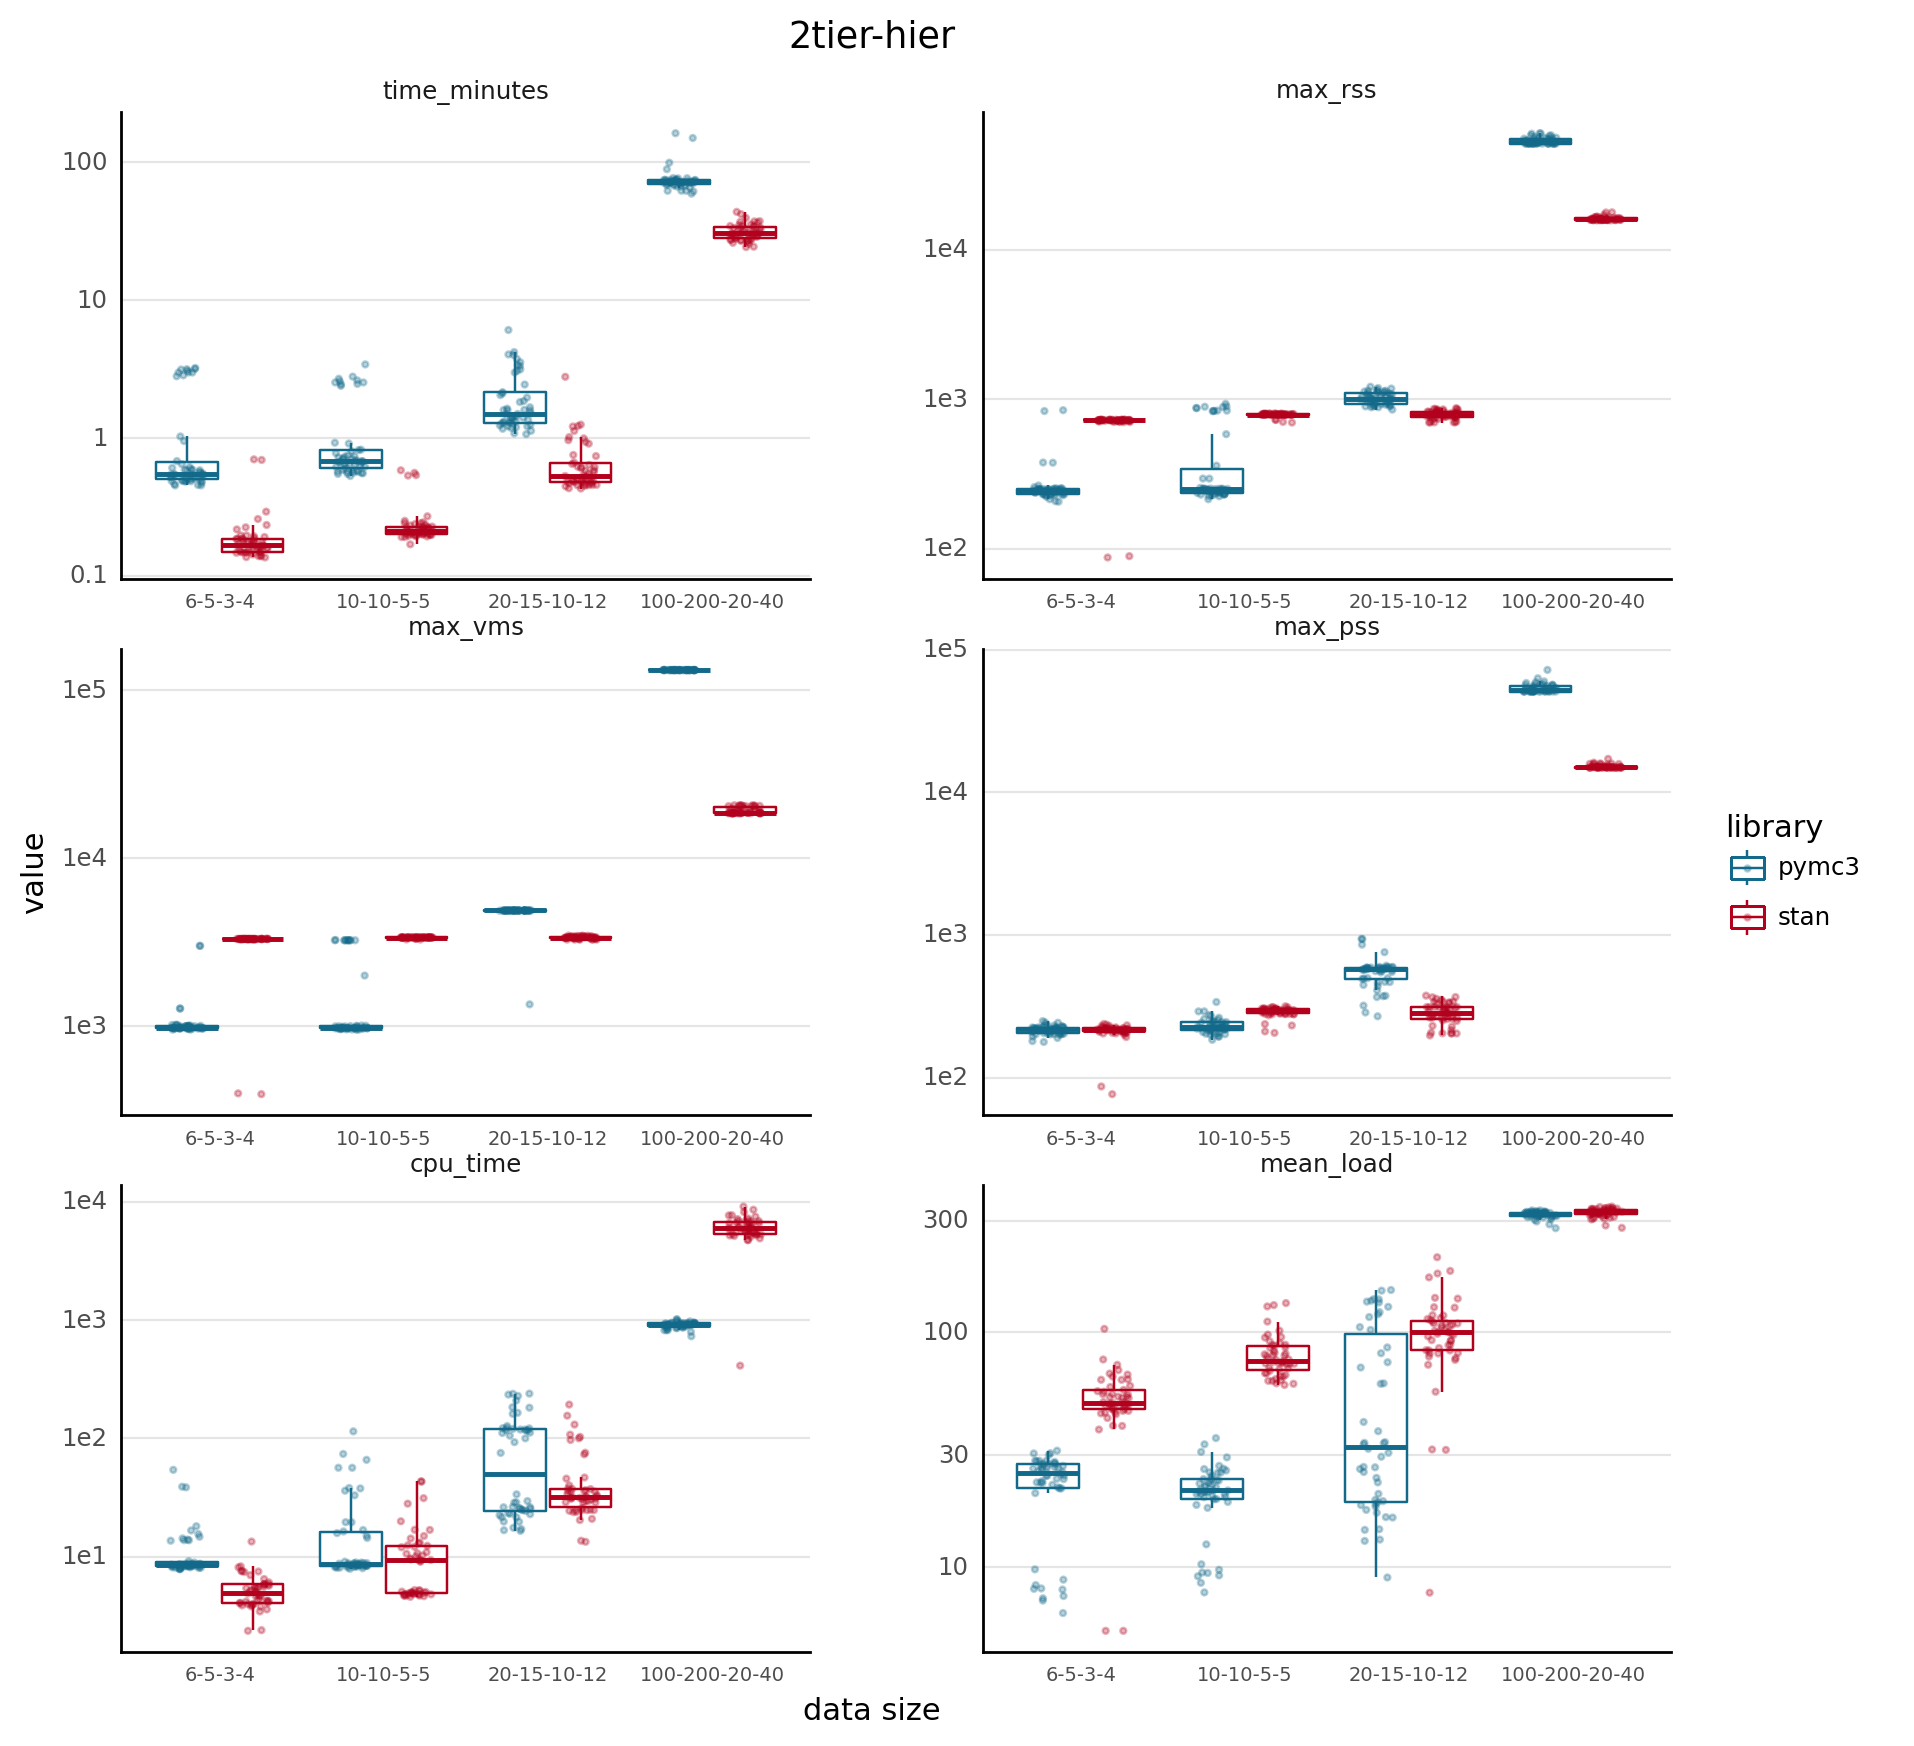

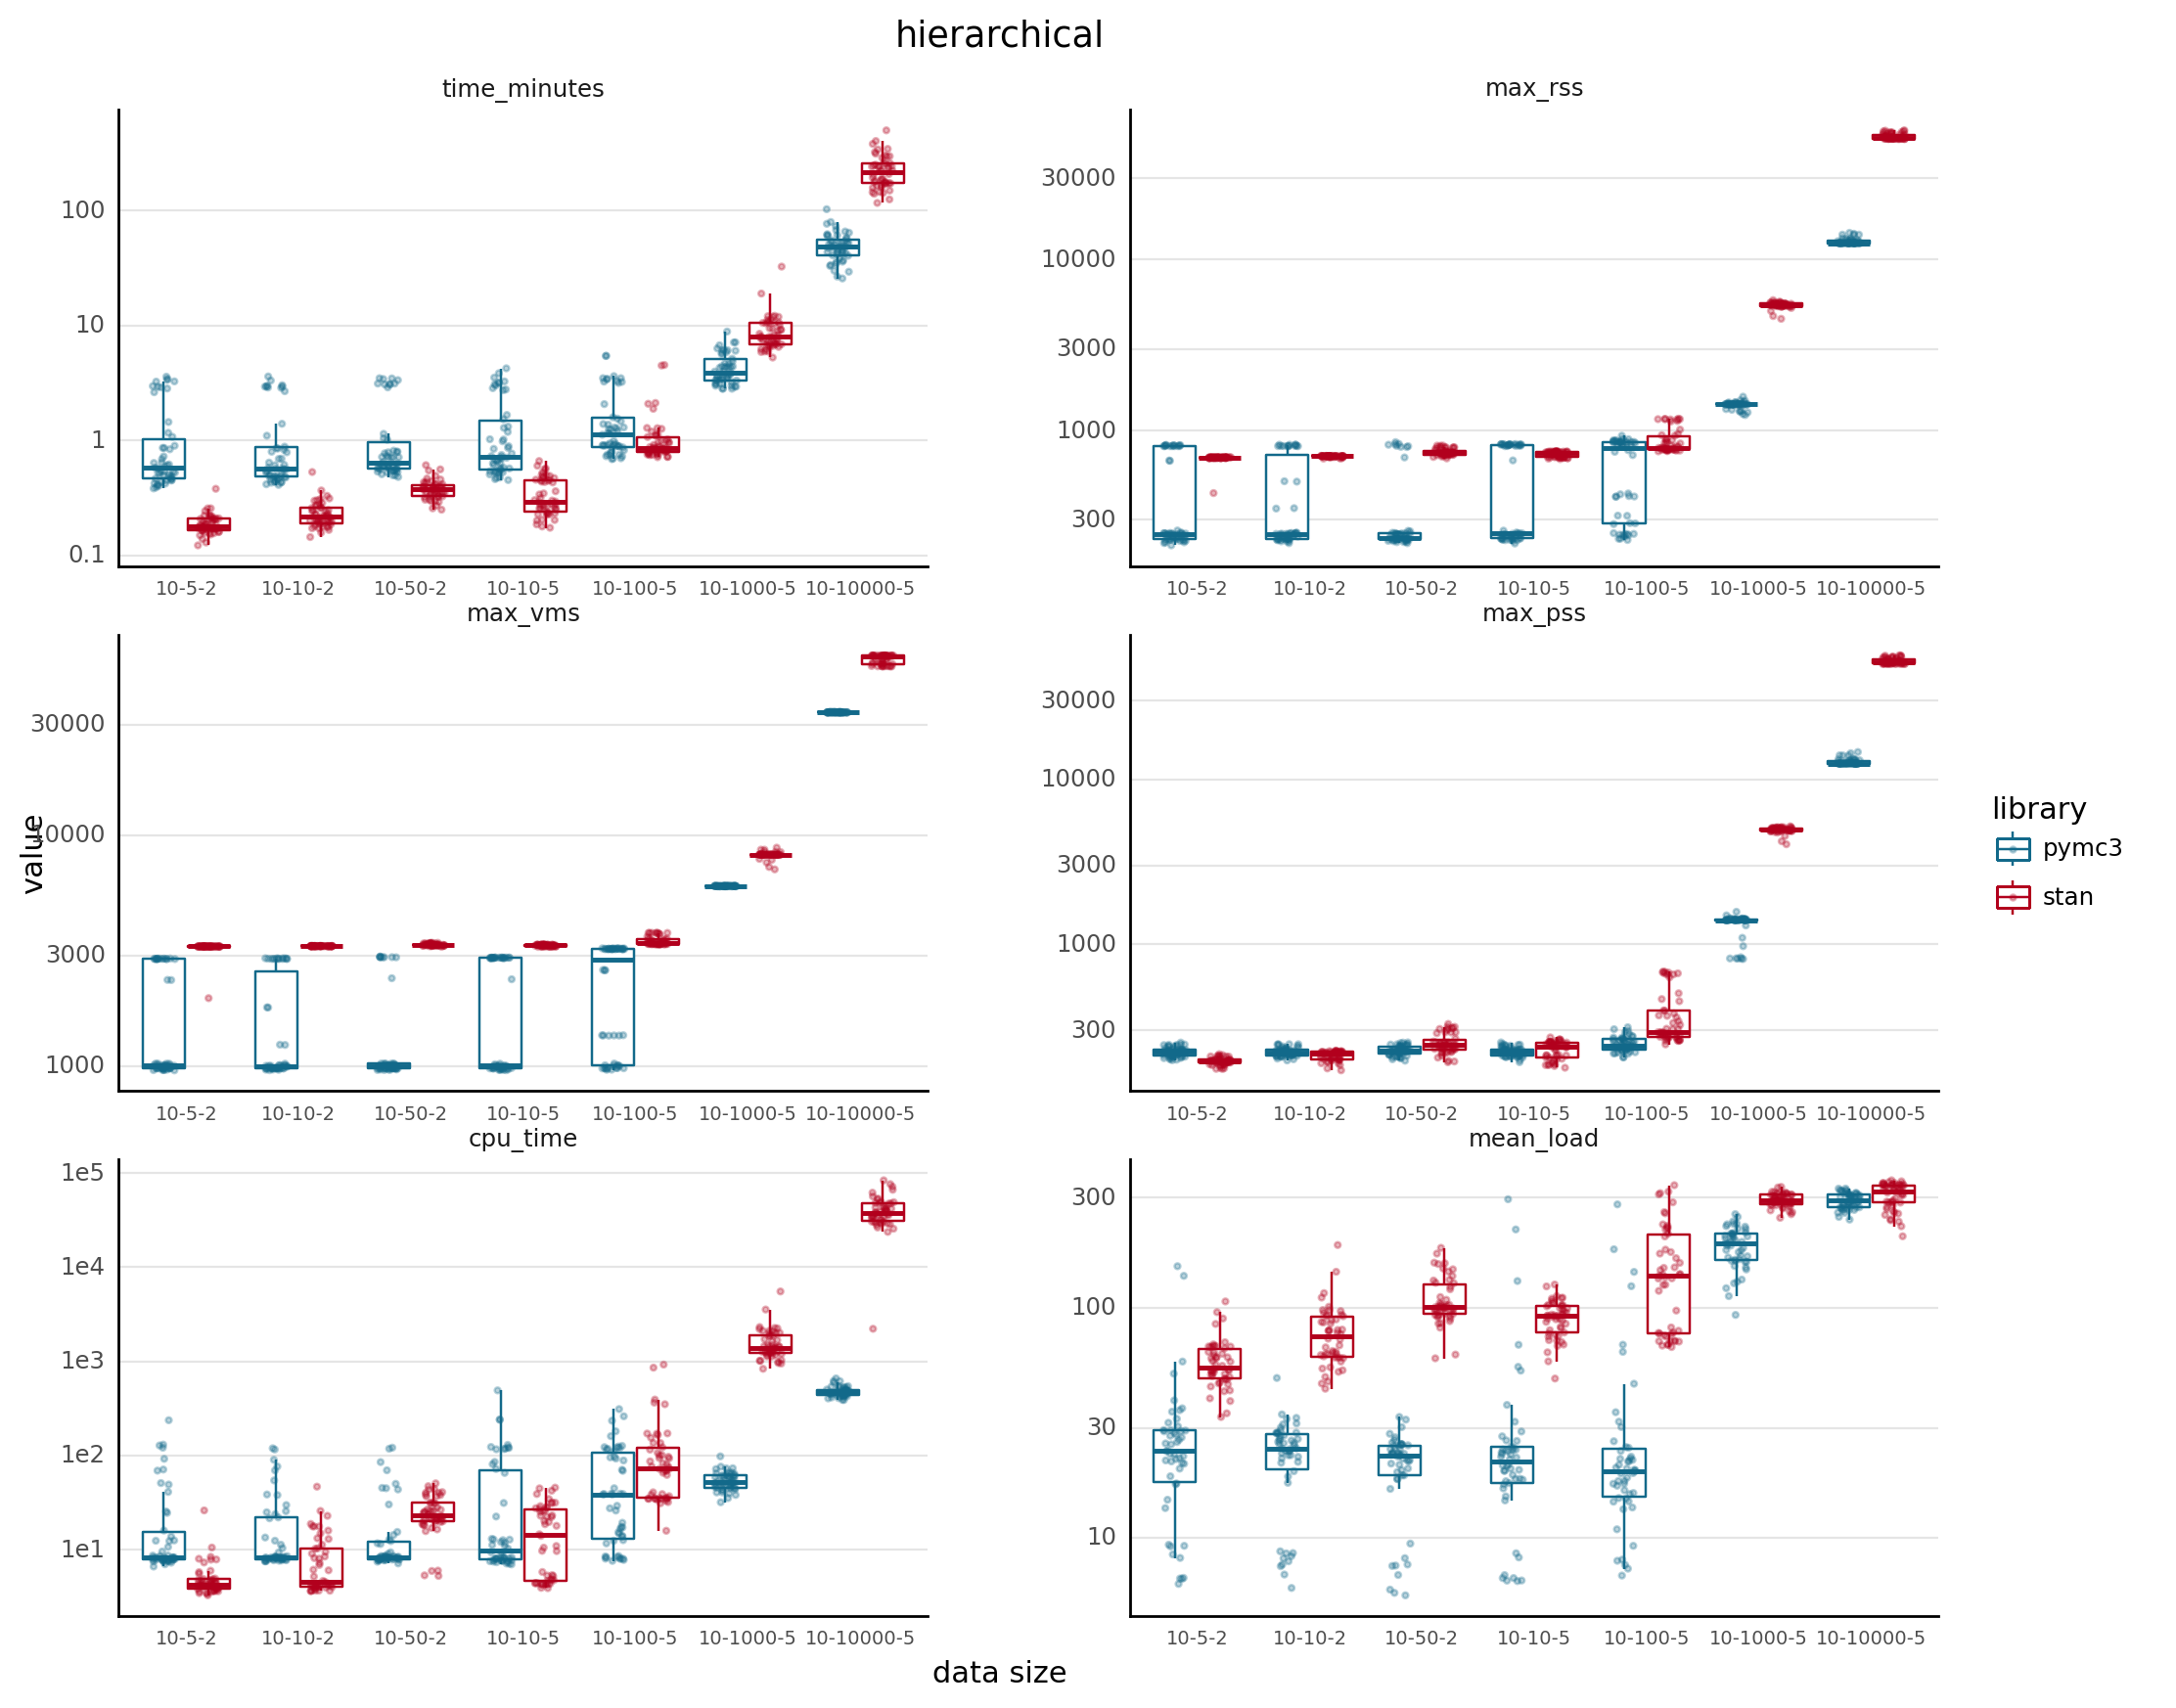

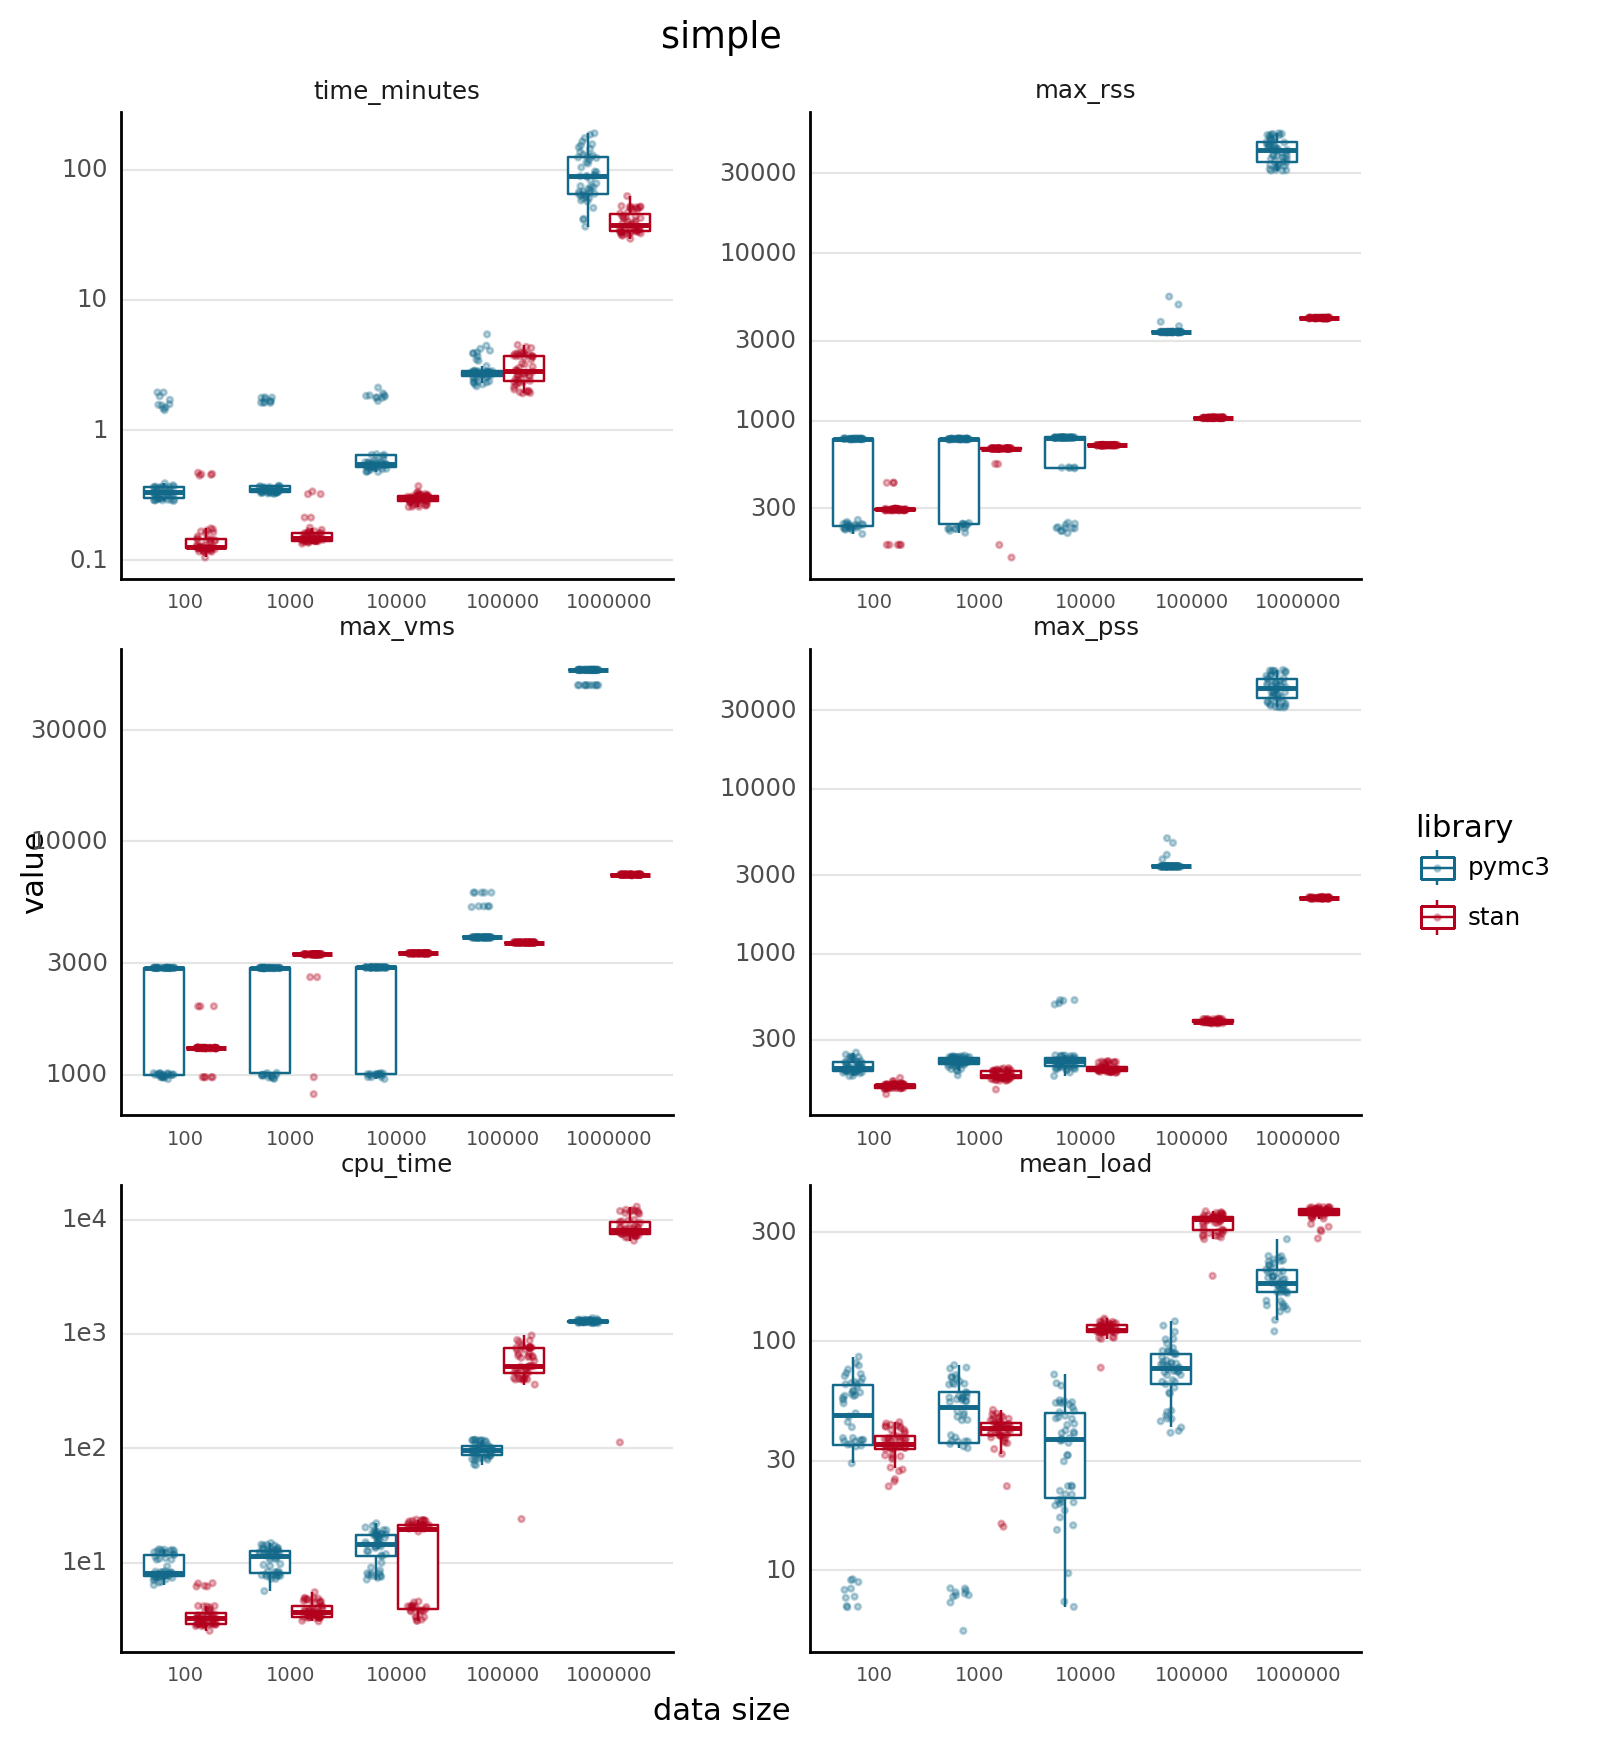

In [7]:
dpos = gg.position_dodge(width=0.8)
jpos = gg.position_jitterdodge(jitter_width=0.2, jitter_height=0, dodge_width=0.8)

_fig_width = {"2tier-hier": 10, "hierarchical": 12}

for model in benchmarks_long.model.unique():
    plot_df = (
        benchmarks_long.query(f"model == '{model}'")
        .copy()
        .pipe(order_data_sizes_by_average_value, variable="time_minutes")
    )
    print(
        gg.ggplot(plot_df, gg.aes(x="factor(data_size)", y="value", color="library"))
        + gg.facet_wrap("variable", scales="free", ncol=2)
        + gg.geom_boxplot(outlier_alpha=0, position=dpos)
        + gg.geom_jitter(size=0.7, alpha=0.3, position=jpos)
        + gg.scale_y_log10()
        + gg.scale_color_manual(values=library_pal)
        + gg.theme(
            axis_text_x=gg.element_text(size=7),
            subplots_adjust={"wspace": 0.25, "hspace": 0.15},
            figure_size=(_fig_width.get(model, 8), 10),
        )
        + gg.labs(x="data size", y="value", color="library", title=model)
    )


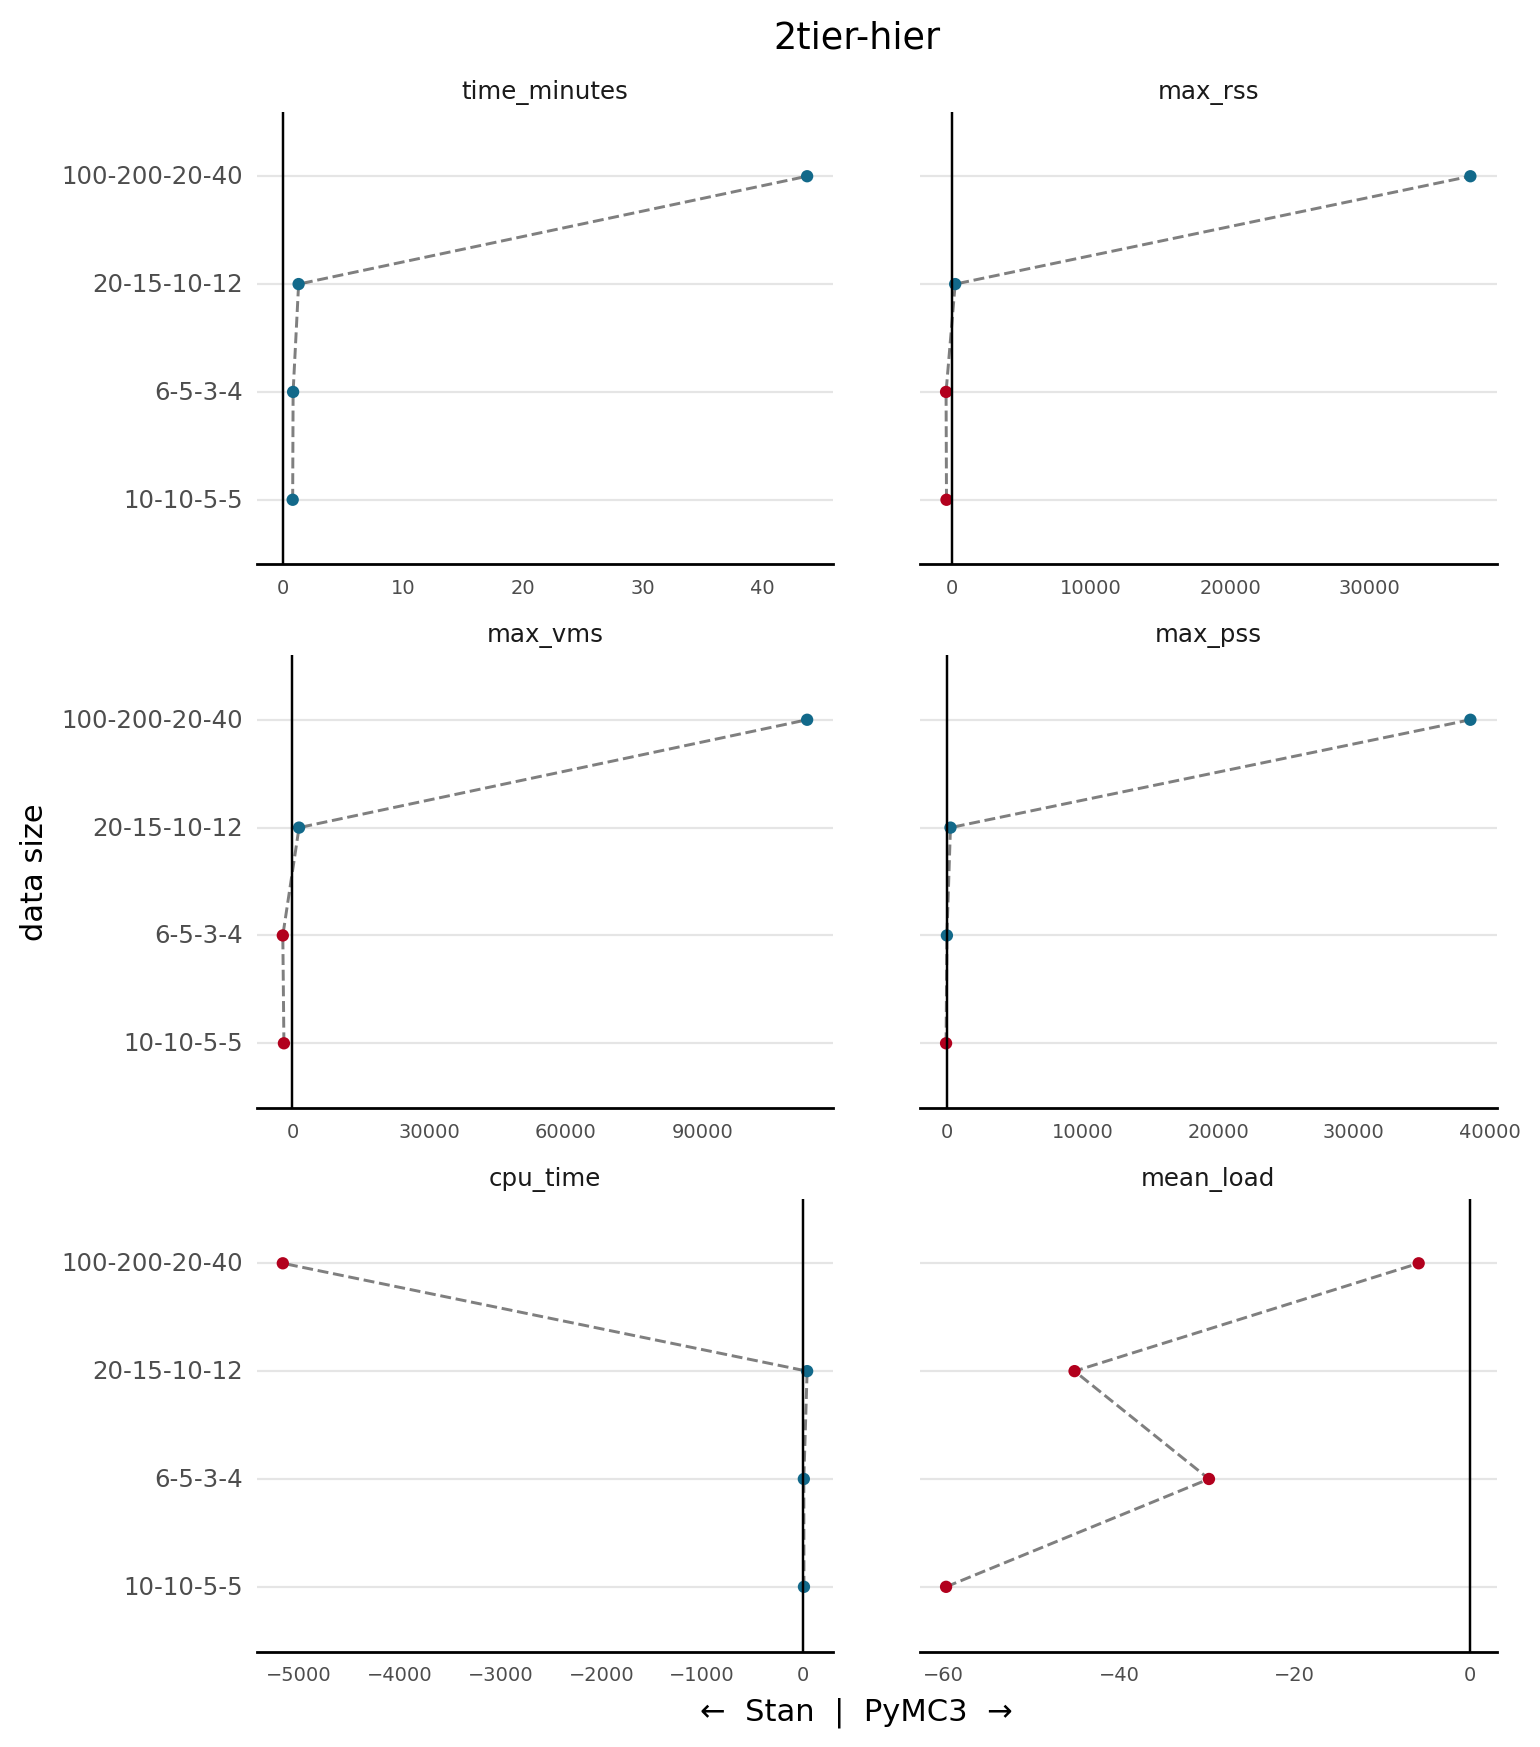

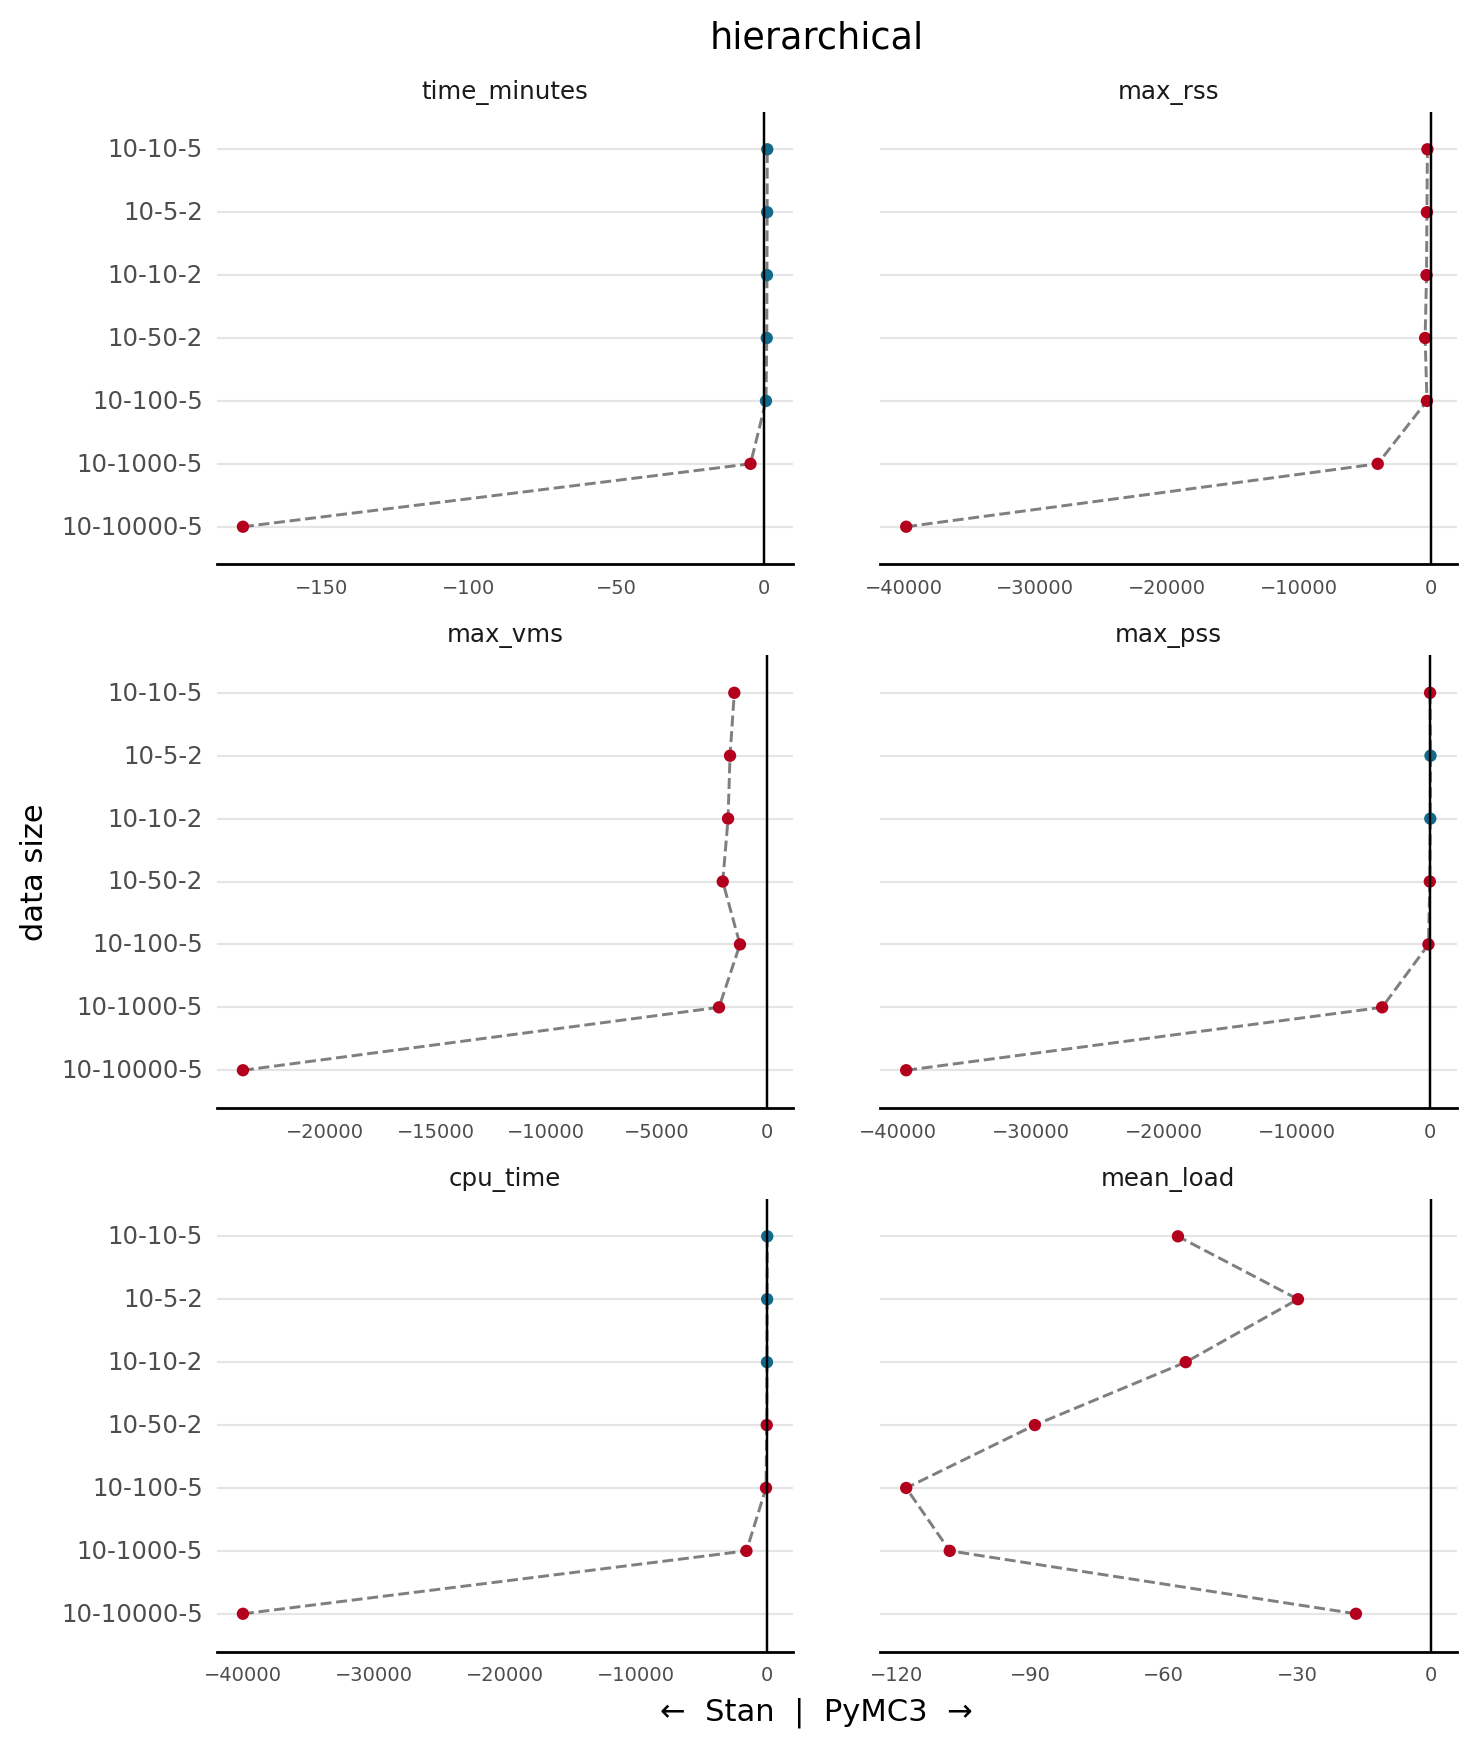

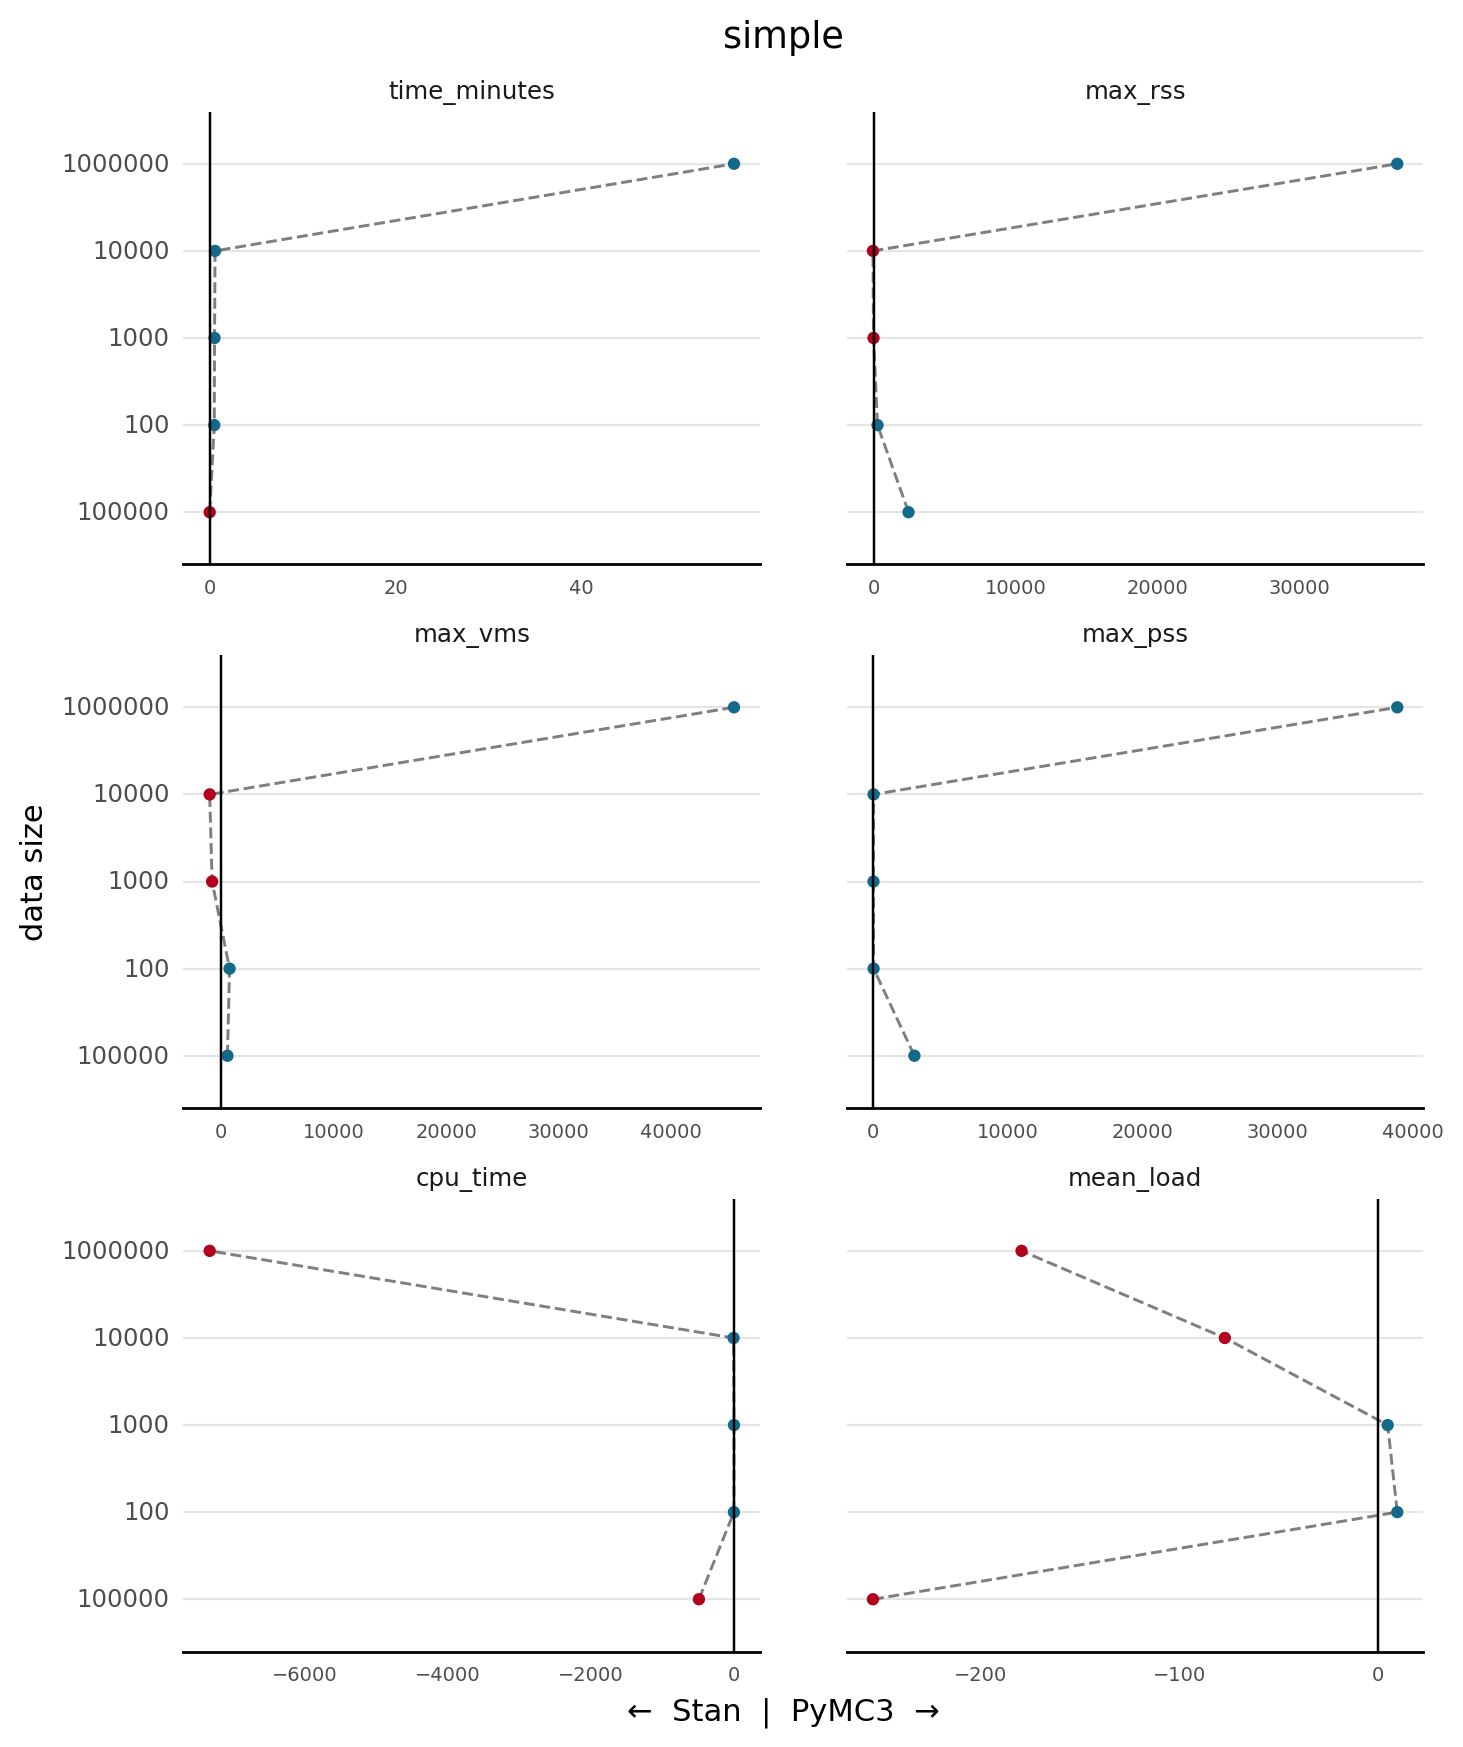

In [8]:
def model_difference(df):
    diff = (
        df[df.library == "pymc3"].value.mean() - df[df.library == "stan"].value.mean()
    )
    return diff


benchmarks_diff = (
    benchmarks_long.groupby(["model", "data_size", "variable"])
    .apply(model_difference)
    .reset_index(drop=False)
    .rename(columns={0: "difference_pymc3_stan"})
)

for model in benchmarks_diff.model.unique():
    _df = (
        benchmarks_diff.query(f"model == '{model}'")
        .assign(
            which_lib=lambda d: [
                "pymc3" if x > 0 else "stan" for x in d.difference_pymc3_stan
            ]
        )
        .pipe(
            order_data_sizes_by_average_value,
            variable="time_minutes",
            col="difference_pymc3_stan",
        )
        .sort_values("data_size")
    )
    print(
        gg.ggplot(_df, gg.aes(y="data_size", x="difference_pymc3_stan"))
        + gg.facet_wrap("~variable", scales="free_x", ncol=2)
        + gg.geom_path(group=1, linetype="--", size=0.6, alpha=0.5)
        + gg.geom_point(gg.aes(color="which_lib"))
        + gg.geom_vline(xintercept=0)
        + gg.scale_color_manual(values=library_pal)
        + gg.theme(
            figure_size=(8, 10),
            axis_text_x=gg.element_text(size=7),
            subplots_adjust={"wspace": 0.15, "hspace": 0.20},
            axis_line_x=gg.element_line(),
            axis_line_y=gg.element_blank(),
            legend_position="none",
        )
        + gg.labs(title=model, x="←  Stan  |  PyMC3  →", y="data size")
    )


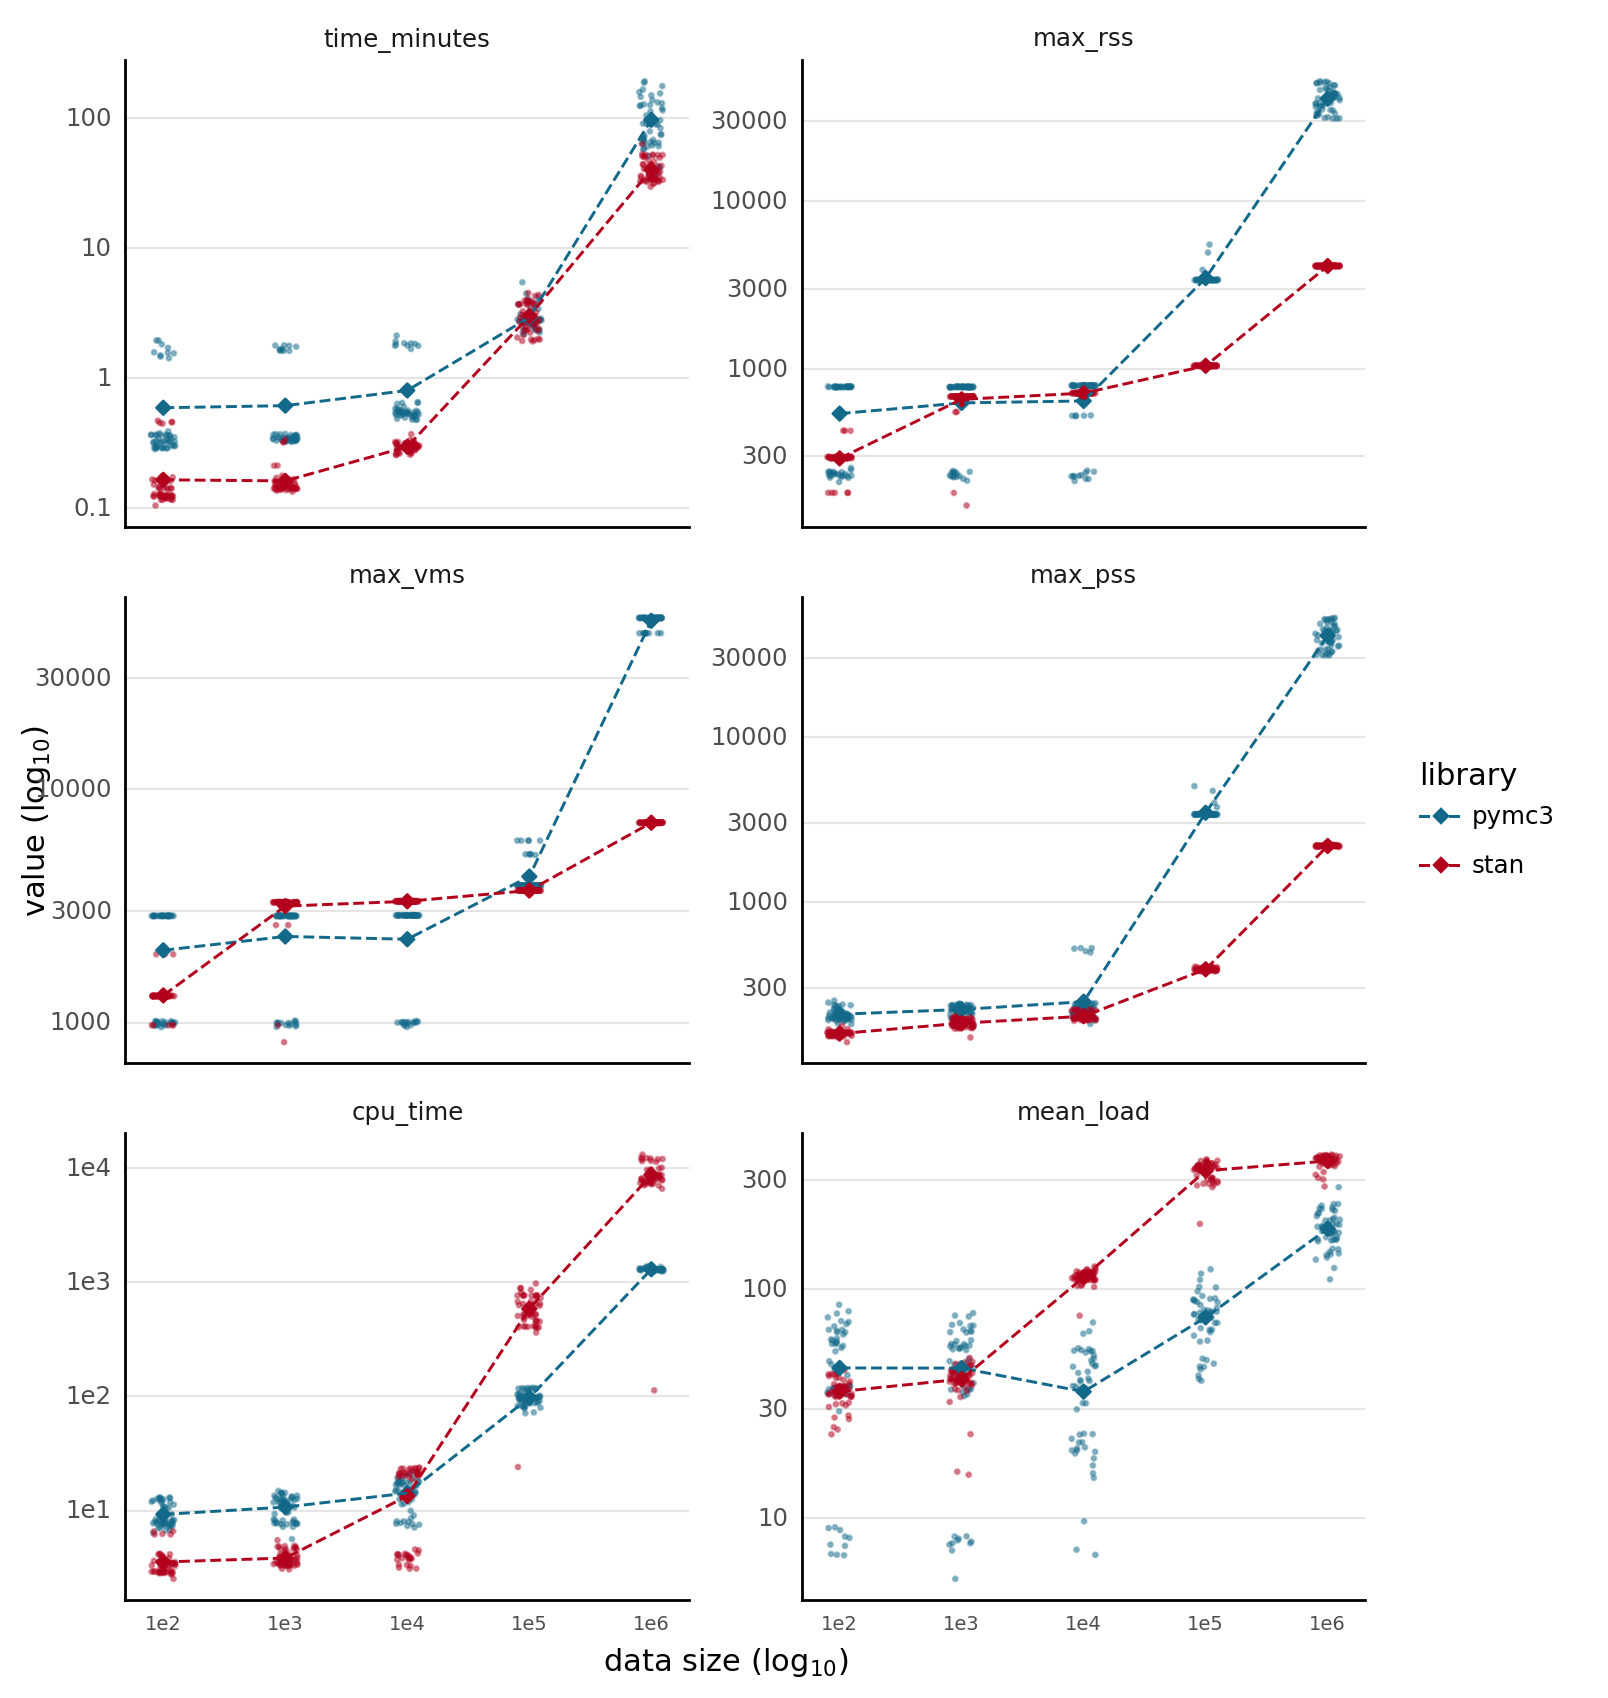

<ggplot: (342898667)>

In [9]:
simple_reg_benchmarks = (
    benchmarks_long.copy().query("model == 'simple'").astype({"data_size": int})
)
simple_reg_benchmarks_avg = (
    simple_reg_benchmarks.groupby(["variable", "library", "data_size"])
    .mean()
    .reset_index(drop=False)
)


(
    gg.ggplot(simple_reg_benchmarks, gg.aes(x="data_size", y="value", color="library"))
    + gg.facet_wrap("variable", scales="free_y", ncol=2)
    + gg.geom_jitter(size=0.4, alpha=0.4, width=0.1, height=0)
    + gg.geom_point(data=simple_reg_benchmarks_avg, shape="D", size=1.5)
    + gg.geom_line(data=simple_reg_benchmarks_avg, linetype="--", size=0.6)
    + gg.scale_x_log10()
    + gg.scale_y_log10()
    + gg.scale_color_manual(values=library_pal)
    + gg.theme(
        axis_text_x=gg.element_text(size=7),
        subplots_adjust={"wspace": 0.2, "hspace": 0.15},
        figure_size=(8, 10),
    )
    + gg.labs(x="data size ($\\log_{10}$)", y="value ($\\log_{10}$)", color="library")
)


In [10]:
hierarchical_mdl_bench = (
    benchmarks_long.copy()
    .query("model == 'hierarchical'")
    .reset_index(drop=True)
    .assign(
        n_pts=lambda d: [int(x.split("-")[0]) for x in d.data_size],
        n_groups=lambda d: [int(x.split("-")[1]) for x in d.data_size],
        n_covs=lambda d: [int(x.split("-")[2]) for x in d.data_size],
    )
)

hierarchical_mdl_bench.head()


,name,model,library,data_size,replicate,variable,value,n_pts,n_groups,n_covs
0,hierarchical_pymc3_10-10-2__1,hierarchical,pymc3,10-10-2,1,time_minutes,2.984062,10,10,2
1,hierarchical_pymc3_10-10-2__1,hierarchical,pymc3,10-10-2,1,time_minutes,0.475132,10,10,2
2,hierarchical_pymc3_10-10-2__1,hierarchical,pymc3,10-10-2,1,time_minutes,0.788087,10,10,2
3,hierarchical_pymc3_10-10-2__1,hierarchical,pymc3,10-10-2,1,time_minutes,0.487678,10,10,2
4,hierarchical_pymc3_10-10-2__1,hierarchical,pymc3,10-10-2,1,time_minutes,0.410117,10,10,2


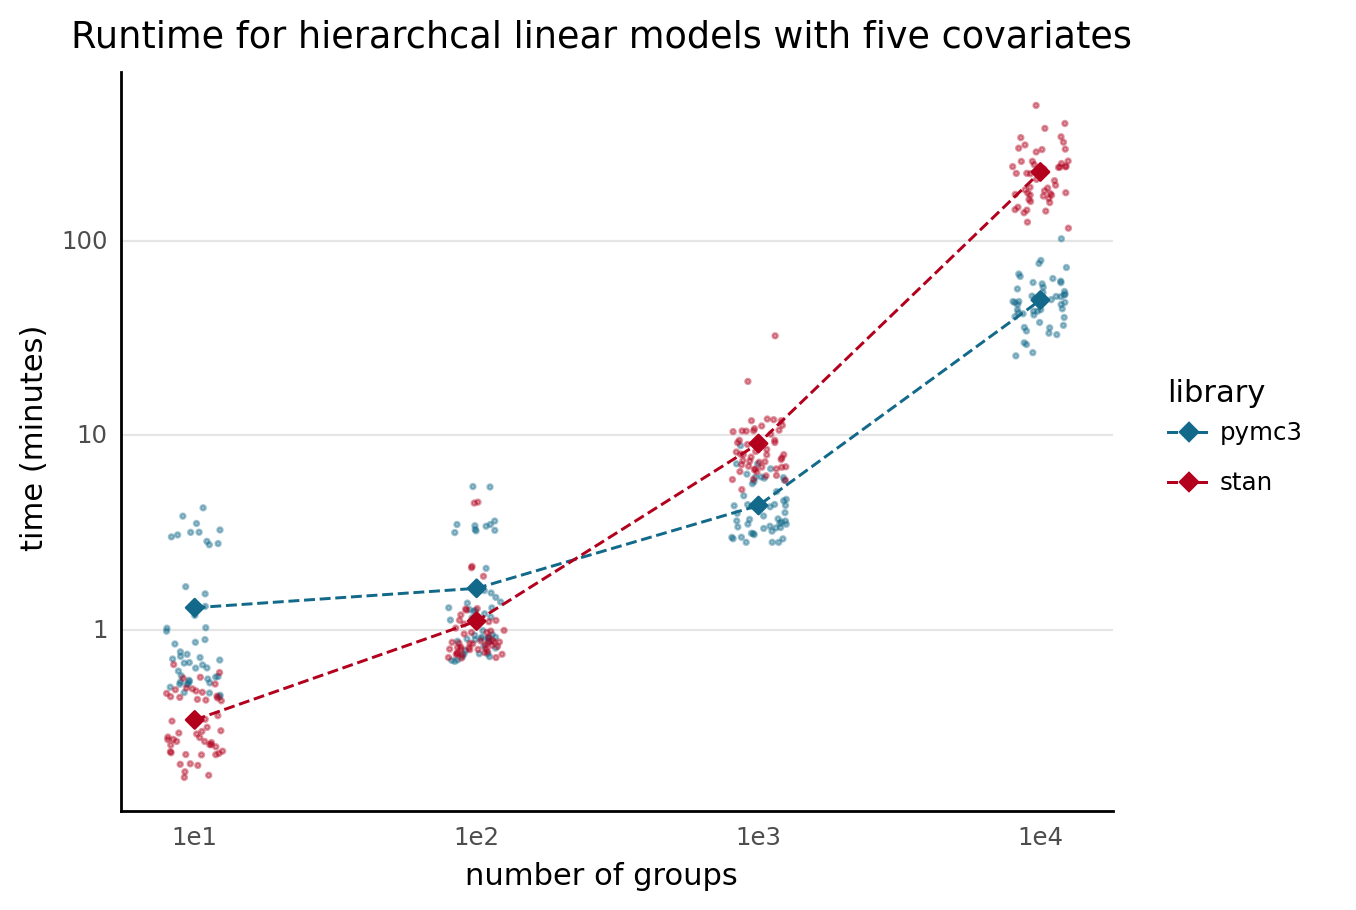

<ggplot: (341334583)>

In [11]:
hier_5cov_df = hierarchical_mdl_bench.copy().query(
    "variable == 'time_minutes' and n_covs == 5"
)

hier_5cov_df_avg = (
    hier_5cov_df.groupby(["n_groups", "library"])["value"]
    .mean()
    .reset_index(drop=False)
)

(
    gg.ggplot(hier_5cov_df, gg.aes(x="factor(n_groups)", y="value", color="library"))
    + gg.geom_jitter(width=0.1, height=0, size=0.5, alpha=0.4)
    + gg.geom_line(
        gg.aes(color="library", group="library"),
        data=hier_5cov_df_avg,
        linetype="--",
        size=0.6,
    )
    + gg.geom_point(data=hier_5cov_df_avg, size=2, shape="D")
    + gg.scale_x_log10()
    + gg.scale_y_log10()
    + gg.scale_color_manual(values=library_pal)
    + gg.labs(
        x="number of groups",
        y="time (minutes)",
        title="Runtime for hierarchcal linear models with five covariates",
    )
)


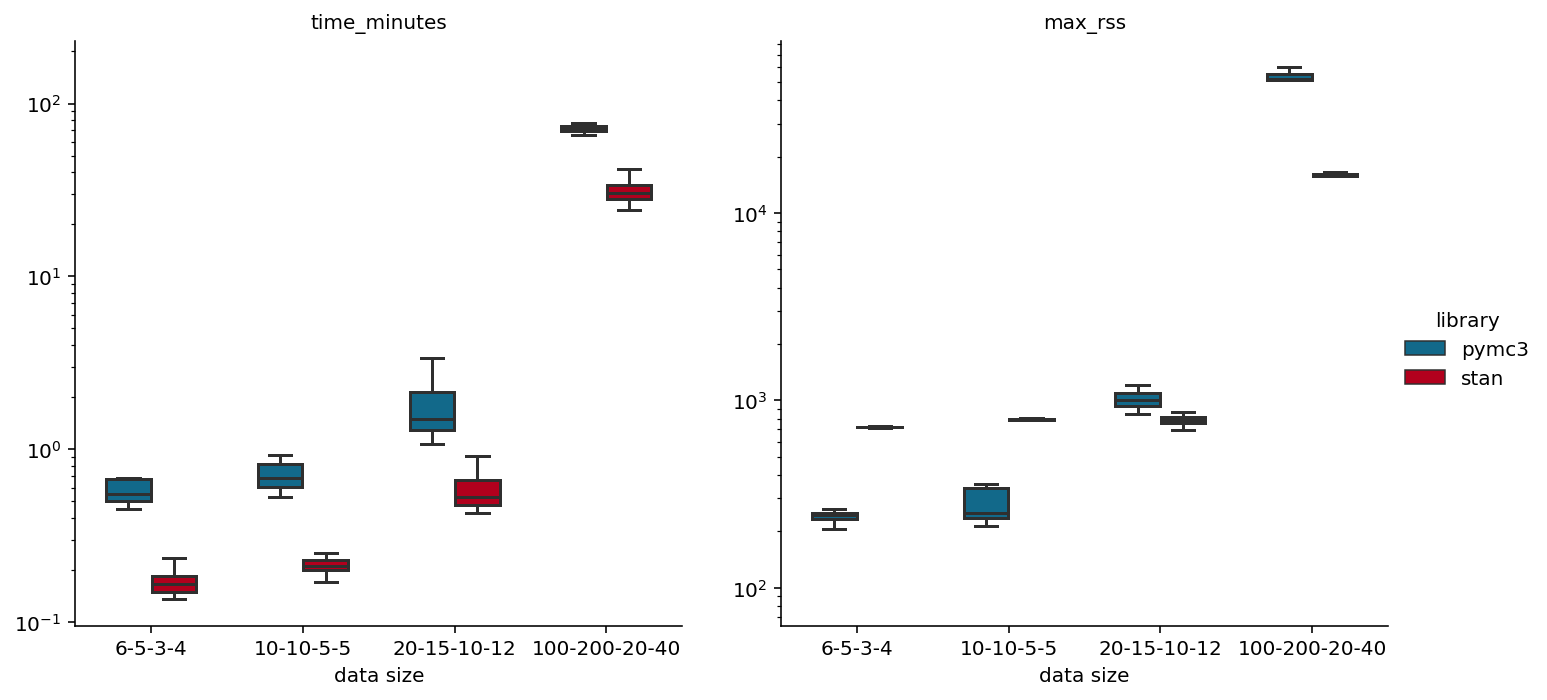

In [12]:
import seaborn as sns

two_tier_bench = (
    benchmarks_long.copy()
    .query("model == '2tier-hier'")
    .filter_column_isin("variable", ["max_rss", "time_minutes"])
    .assign(variable=lambda d: d["variable"].astype(str))
    .pipe(order_data_sizes_by_average_value, variable="time_minutes")
)

sns.catplot(
    data=two_tier_bench,
    kind="box",
    x="data_size",
    y="value",
    hue="library",
    col="variable",
    palette=library_pal,
    sharey=False,
    width=0.6,
    saturation=1,
    dodge=True,
    fliersize=0,
).set_titles("{col_name}").set(yscale="log", xlabel="data size", ylabel=None)


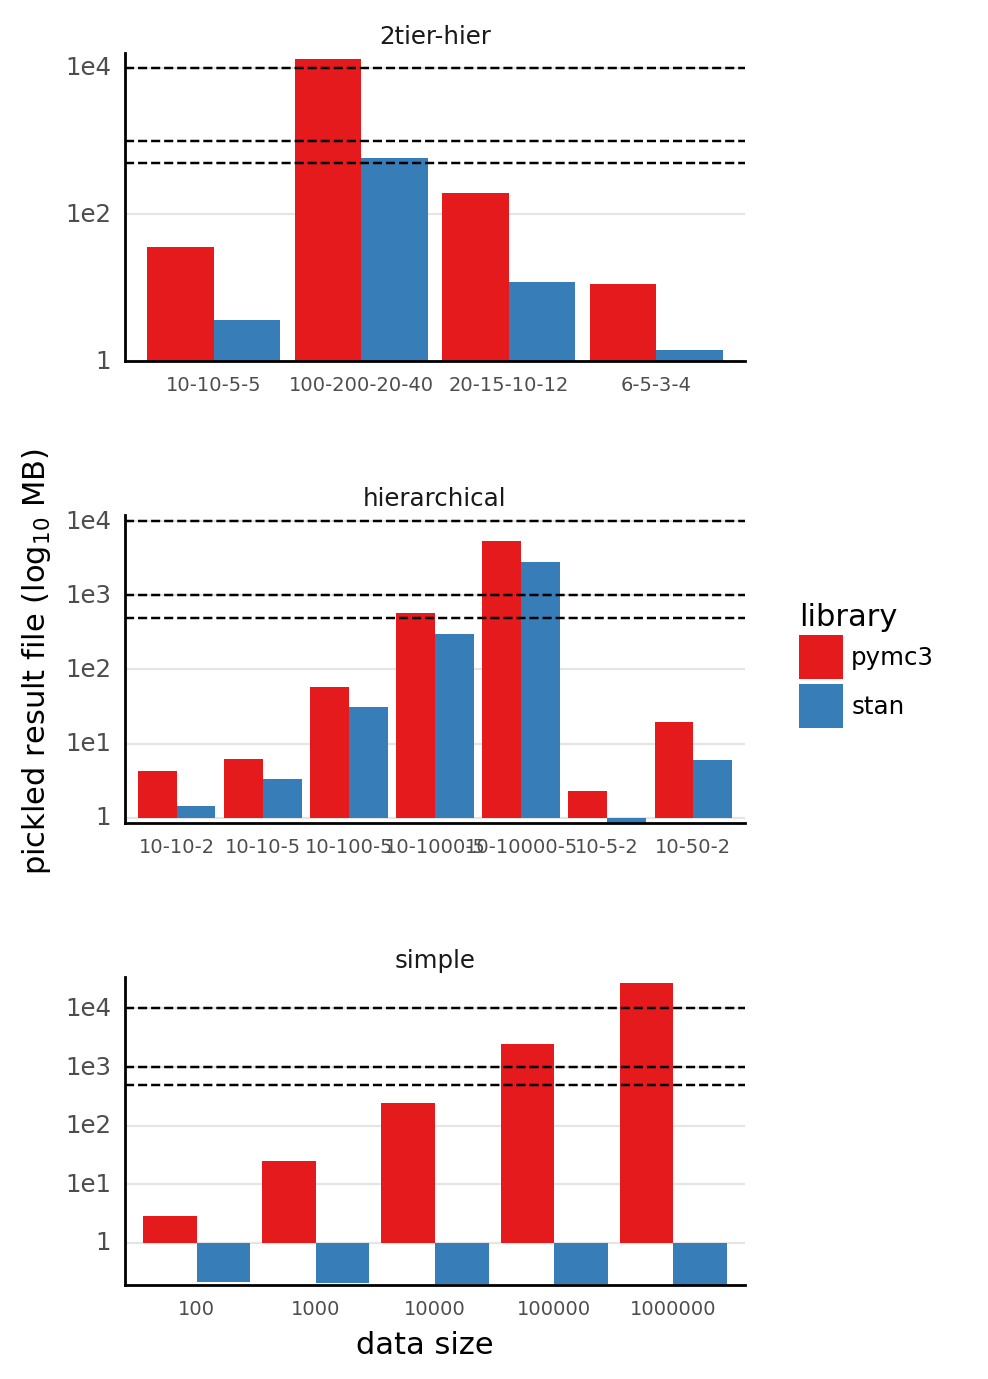

<ggplot: (343762327)>

In [16]:
result_file_sizes = pd.read_csv(model_size_csv).filter_string("name", "__").pipe(parse_model_names)

breaks: dict[str, float] = {"0.5 GB": 500, "1 GB": 1000, "10 GB": 10000}

(
    gg.ggplot(result_file_sizes, gg.aes(x="data_size", y="mb", fill="library"))
    + gg.facet_wrap("model", ncol=1, scales="free")
    + gg.geom_col(position="dodge")
    + gg.geom_hline(yintercept=breaks.values(), linetype="--", color="black")
    + gg.scale_y_log10(expand=(0, 0, 0.02, 0))
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.theme(
        panel_grid_major_y=gg.element_line(),
        axis_text_x=gg.element_text(size=7),
        figure_size=(4, 8),
        subplots_adjust={"hspace": 0.5},
    )
    + gg.labs(x="data size", y="pickled result file ($\\log_{10}$ MB)", fill="library")
)


---

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-12-26

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: custom-benchmarking

re      : 2.2.1
sys     : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 20:33:18) 
[Clang 11.1.0 ]
plotnine: 0.8.0
janitor : 0.21.2
pandas  : 1.3.4

